In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [97]:
# Read in the dataframe.
df_11_12 = pd.read_csv('data/benj_data/play_by_play_2011_12.csv.gz', encoding='latin1')
# df_11_12.head()

C:\Users\benja\AppData\Local\Temp\ipykernel_1040\3728607930.py:2: DtypeWarning: Columns (54) have mixed types. Specify dtype option on import or set low_memory=False.
  df_11_12 = pd.read_csv('data/benj_data/play_by_play_2011_12.csv.gz', encoding='latin1')


In [98]:
def get_data(df, game_id):
    """
    Extracts and organizes event data for a specific game.

    Args:
    df (DataFrame): The DataFrame containing the game data.
    game_id (int): The ID of the game to retrieve data for.

    Returns:
    tuple: A tuple containing two DataFrames, one for home team events and one for away team events.
    """

    # Filter the DataFrame to get data for the specified game and drop rows with NaN values in event_team_type
    game1 = df[df.game_id == game_id] 
    game1 = game1.dropna(subset=['event_team_type'])

    # Get unique event types (excluding CHANGE)
    event_types = game1.event_type.unique()
    event_types = np.delete(event_types, np.where(event_types == 'CHANGE'))
    event_types = np.append(event_types, ['TIME_REMAINING', 'HOME', 'WIN', 'TEAM', 'GAME_ID'])

    # Create dictionaries to store event counts for home and away teams
    home_dict = {event: 0 for event in event_types}
    away_dict = {event: 0 for event in event_types}

    # Create DataFrames to store event data for home and away teams
    home_df = pd.DataFrame(columns=home_dict.keys())
    away_df = pd.DataFrame(columns=away_dict.keys())

    # Iterate through the events in the game and count them
    for _, row in game1.iterrows():
        # Skip events with NaN event_team_type or events of type CHANGE
        if pd.isnull(row['event_team_type']) or row['event_type'] == 'CHANGE':
            continue
        
        # Determine if the event belongs to the home or away team and update counts accordingly
        if row['event_team_type'] == 'home':
            home_dict[row['event_type']] += 1
            home_dict['TIME_REMAINING'] = row['game_seconds_remaining']
            home_dict['HOME'] = 1
            home_dict['WIN'] = 1 if row['home_final'] > row['away_final'] else 0
            home_dict['TEAM'] = row['team_encoded']
            home_dict['GAME_ID'] = game_id
            home_df = pd.concat([home_df, pd.DataFrame([home_dict])], ignore_index=True)
        else:
            away_dict[row['event_type']] += 1
            away_dict['TIME_REMAINING'] = row['game_seconds_remaining']
            away_dict['HOME'] = 0
            away_dict['WIN'] = 1 if row['home_final'] < row['away_final'] else 0
            away_dict['TEAM'] = row['team_encoded']
            away_dict['GAME_ID'] = game_id
            away_df = pd.concat([away_df, pd.DataFrame([away_dict])], ignore_index=True)
        
    return home_df, away_df

def get_label_encoder(teams):
    le = LabelEncoder()
    le.fit(teams)
    return le

In [99]:
# Copy the dataframe (so we don't have to reload it)
df_copy = df_11_12.copy()

# Drop NaN's from event_team_type (drops events that are not helpful)
    # This includes things like game stats, end of periods, etc.
df_copy = df_copy.dropna(subset=['event_team'])

# Get all of the unique game ids, thus getting all of the games
unique_game_ids = df_11_12.game_id.unique()

# Get the label encoder for the teams
team_names = np.sort(df_copy.event_team.dropna().unique())  # Sort first to make sure the encoding is consistent
label_encoder = get_label_encoder(team_names)               # Get the label encoder (helper function)

# Label encode the teams
df_copy['team_encoded'] = label_encoder.transform(df_copy.event_team)

# Iterate through the games
final_df = pd.DataFrame()
for game_id in unique_game_ids:
    home_df, away_df = get_data(df_copy, game_id)
    final_df = pd.concat([final_df, home_df], ignore_index=True)
    final_df = pd.concat([final_df, away_df], ignore_index=True)

In [107]:
home = home_df.copy()
away = away_df.copy()

In [108]:
def merge_home_away(home_df, away_df):
     # change the names in the home_df to be HOME_[current column name] and same for away_df
     home_df.columns = ['HOME_' + col for col in home_df.columns]
     away_df.columns = ['AWAY_' + col for col in away_df.columns]
     # change TIME_REMAINING, WIN, GAME_ID to be the same in both dataframes
     home_df = home_df.rename(columns={'HOME_TIME_REMAINING': 'TIME_REMAINING', 'HOME_WIN': 'WIN', 'HOME_GAME_ID': 'GAME_ID'})
     away_df = away_df.rename(columns={'AWAY_TIME_REMAINING': 'TIME_REMAINING', 'AWAY_WIN': 'WIN', 'AWAY_GAME_ID': 'GAME_ID'})

     full = pd.merge(home_df, away_df, on=['TIME_REMAINING', 'WIN', 'GAME_ID'], how='outer')

     # if home_df has 1 in WIN column than make all the values in the WIN column 1
     if 1 in home_df.WIN.unique():
          full.WIN = 1
     elif 1 in away_df.WIN.unique():
          full.WIN = 0

     full.drop(columns=['HOME_HOME', 'AWAY_HOME'])
     full = full.sort_values(by='TIME_REMAINING')
     full.fillna(method='ffill', inplace=True)
     full.fillna(0, inplace=True)

     return full

In [109]:
full = merge_home_away(home, away)

C:\Users\benja\AppData\Local\Temp\ipykernel_1040\3425495814.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  full.fillna(method='ffill', inplace=True)
C:\Users\benja\AppData\Local\Temp\ipykernel_1040\3425495814.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full.fillna(method='ffill', inplace=True)


In [110]:
# put WIN at the end
cols = list(full.columns)
cols.remove('WIN')
cols.append('WIN')

full = full[cols]
full.head()

,HOME_FACEOFF,HOME_HIT,HOME_BLOCKED_SHOT,HOME_GIVEAWAY,HOME_SHOT,HOME_PENALTY,HOME_MISSED_SHOT,HOME_TAKEAWAY,HOME_GOAL,TIME_REMAINING,...,AWAY_BLOCKED_SHOT,AWAY_GIVEAWAY,AWAY_SHOT,AWAY_PENALTY,AWAY_MISSED_SHOT,AWAY_TAKEAWAY,AWAY_GOAL,AWAY_HOME,AWAY_TEAM,WIN
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,...,9,16,17,9,11,1,1,0,16,1
1,34.0,34.0,16.0,21.0,19.0,3.0,16.0,5.0,6.0,13,...,9,16,17,9,11,1,1,0,16,1
2,34.0,34.0,16.0,20.0,19.0,3.0,16.0,5.0,6.0,42,...,9,16,17,9,11,1,1,0,16,1
3,34.0,34.0,16.0,20.0,19.0,3.0,16.0,5.0,6.0,64,...,9,16,16,9,11,1,1,0,16,1
4,34.0,34.0,16.0,20.0,19.0,3.0,16.0,5.0,6.0,67,...,9,16,15,9,11,1,1,0,16,1


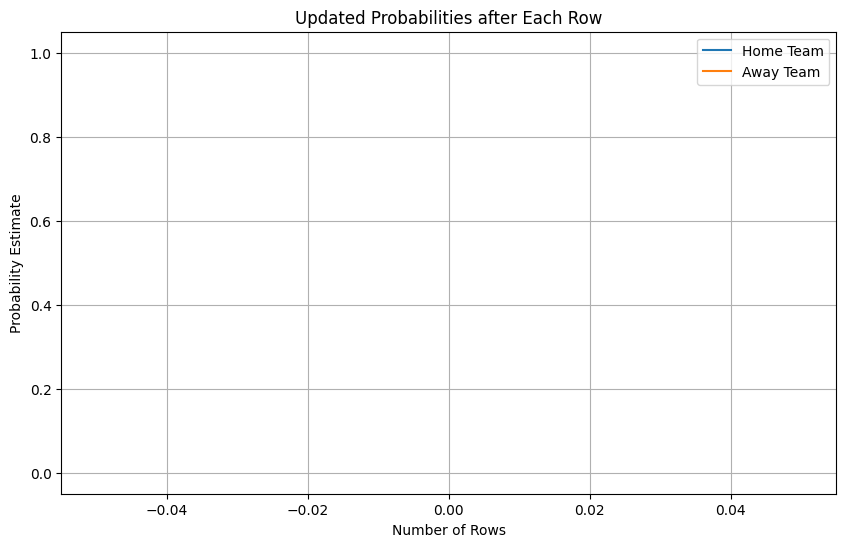

In [120]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

# Load the data
data = full

# Initialize lists to store probabilities after each row
home_probabilities = []
away_probabilities = []

# Convert data to TensorFlow tensors
X = tf.convert_to_tensor(data.iloc[:, :-1].values, dtype=tf.float32)
y = tf.convert_to_tensor(data.iloc[:, -1].values, dtype=tf.float32)

# Define the linear regression model
def linear_regression(X, beta):
    return tf.linalg.matmul(X, beta)

# Define priors
initial_beta = tf.random.normal([X.shape[1], 1])
beta = tf.Variable(initial_beta, name='beta')
initial_sigma = tf.constant(1.0, dtype=tf.float32)
sigma = tfp.util.TransformedVariable(initial_sigma, tfp.bijectors.Softplus(), dtype=tf.float32, name='sigma')

# Define negative log likelihood
@tf.function
def negative_log_likelihood():
    mu = linear_regression(X, beta)
    dist = tfp.distributions.Normal(loc=mu, scale=sigma)
    return -tf.reduce_sum(dist.log_prob(y))

# Use Adam optimizer to minimize negative log likelihood
optimizer = tf.optimizers.Adam()
for i in range(X.shape[0]):
    optimizer.minimize(negative_log_likelihood, [beta])
    
    # Calculate probability estimate after each row
    mu = linear_regression(X[:i+1], beta)
    dist = tfp.distributions.Normal(loc=mu, scale=sigma)
    home_probability = dist.prob(y[:i+1]).numpy().mean()  # Calculate mean probability for the home team
    away_probability = 1 - home_probability  # Away team probability is the complement of the home team probability
    home_probabilities.append(home_probability)
    away_probabilities.append(away_probability)

# Plot probabilities after each row
plt.figure(figsize=(10, 6))
plt.plot(home_probabilities, label='Home Team')
plt.plot(away_probabilities, label='Away Team')
plt.xlabel('Number of Rows')
plt.ylabel('Probability Estimate')
plt.title('Updated Probabilities after Each Row')
plt.legend()
plt.grid(True)
plt.show()


In [122]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

# Load the data
data = full

# Check for missing values
print("Missing Values:\n", data.isnull().sum())

# Drop rows with missing values or fill them with appropriate values
# For simplicity, let's drop rows with missing values
data.dropna(inplace=True)

# Separate features and target variable
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Standardize features
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Define the linear regression model
def linear_regression(X, beta):
    return tf.linalg.matmul(X, beta)

# Define priors
initial_beta = tf.random.normal([X.shape[1], 1])
beta = tf.Variable(initial_beta, name='beta')
initial_sigma = tf.constant(1.0, dtype=tf.float32)
sigma = tfp.util.TransformedVariable(initial_sigma, tfp.bijectors.Softplus(), dtype=tf.float32, name='sigma')

# Define negative log likelihood
@tf.function
def negative_log_likelihood():
    mu = linear_regression(X, beta)
    dist = tfp.distributions.Normal(loc=mu, scale=sigma)
    return -tf.reduce_sum(dist.log_prob(y))

# Use Adam optimizer to minimize negative log likelihood
optimizer = tf.optimizers.Adam()
for i in range(X.shape[0]):
    optimizer.minimize(negative_log_likelihood, [beta])
    
    # Calculate probability estimate after each row
    mu = linear_regression(X[:i+1], beta)
    dist = tfp.distributions.Normal(loc=mu, scale=sigma)
    home_probability = dist.prob(y[:i+1]).numpy().mean()  # Calculate mean probability for the home team
    away_probability = 1 - home_probability  # Away team probability is the complement of the home team probability
    
    # Debugging: Print intermediate values
    print("Iteration:", i)
    print("Mu:", mu.numpy()[:5])  # Print first 5 values of mu
    print("Home Probability:", home_probability)
    print("Away Probability:", away_probability)
    print("----------------------")

# Plot probabilities after each row
plt.figure(figsize=(10, 6))
plt.plot(home_probabilities, label='Home Team')
plt.plot(away_probabilities, label='Away Team')
plt.xlabel('Number of Rows')
plt.ylabel('Probability Estimate')
plt.title('Updated Probabilities after Each Row')
plt.legend()
plt.grid(True)
plt.show()


Missing Values:
 HOME_FACEOFF         0
HOME_HIT             0
HOME_BLOCKED_SHOT    0
HOME_GIVEAWAY        0
HOME_SHOT            0
HOME_PENALTY         0
HOME_MISSED_SHOT     0
HOME_TAKEAWAY        0
HOME_GOAL            0
TIME_REMAINING       0
HOME_HOME            0
HOME_TEAM            0
GAME_ID              0
AWAY_FACEOFF         0
AWAY_HIT             0
AWAY_BLOCKED_SHOT    0
AWAY_GIVEAWAY        0
AWAY_SHOT            0
AWAY_PENALTY         0
AWAY_MISSED_SHOT     0
AWAY_TAKEAWAY        0
AWAY_GOAL            0
AWAY_HOME            0
AWAY_TEAM            0
WIN                  0
dtype: int64


C:\Users\benja\AppData\Local\Temp\ipykernel_1040\3789727513.py:22: RuntimeWarning: invalid value encountered in divide
  X = (X - X.mean(axis=0)) / X.std(axis=0)


TypeError: in user code:

    File "C:\Users\benja\AppData\Local\Temp\ipykernel_1040\3789727513.py", line 37, in negative_log_likelihood  *
        mu = linear_regression(X, beta)
    File "C:\Users\benja\AppData\Local\Temp\ipykernel_1040\3789727513.py", line 26, in linear_regression  *
        return tf.linalg.matmul(X, beta)

    TypeError: Input 'b' of 'MatMul' Op has type float32 that does not match type float64 of argument 'a'.
